# Popularity Prediction of User-Posts 
# on the website of Austrian Newspaper 'Der Standard'

This noteboook deal with the challenge of prediction the popularity (measured by up- and downvotes) of user-posts in the comments-section under articles of the Austrian Newspaper 'Der Standard'.

## Step 0: Set Up

In [9]:
 #!pip install jupyter_contrib_nbextensions
 #!jupyter contrib nbextension install --user
!pip install pydot --user
# python -m pip install pydot --user
!pip install graphviz --user
!pip install tqdm --user

### Step 0.1 Load Libraries

As a first step we load in the necessary libraries that we will use to accomplish this task.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import sqlite3
from transformers import pipeline

# for tracking time
from tqdm import tqdm
tqdm.pandas()

# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import textwrap
from tabulate import tabulate

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, concatenate, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer, TFBertModel


# Text processing
import re
import string
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer


# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 0.2 Load Data

In [2]:
# Relative path to the SQLite database file
database_file = "./data/corpus.sqlite3"

# Connect to the database
conn = sqlite3.connect(database_file)

# Query to fetch the first 100,000 rows from a table named 'your_table_name'
query = "SELECT * FROM Posts LIMIT 100000"

# Load data into a DataFrame
df_posts = pd.read_sql_query(query, conn)
df_articles = pd.read_sql_query("SELECT * FROM Articles", conn)

# Close the connection
conn.close()


## Step 1: Preprocessing

###  Step 1.0 Merging the two datasets

In [3]:
# Extracting the subtitle from the articles body
def extract_subtitle(html_content):
    match = re.search(r'<h2.*?>(.*?)<\/h2>', html_content)
    return match.group(1) if match else " "
df_articles['Subtitle'] = df_articles['Body'].apply(extract_subtitle)


# Merge the two DataFrames based on the 'ID_Article' column

# excluding the full articles body and only including title and subtitle in the merge
# as the body is usually quite long and might not contain valuable information for this analysis
columns_to_merge = df_articles.columns[df_articles.columns != 'Body']

df_merged = pd.merge(df_posts, df_articles[columns_to_merge], on='ID_Article')

# Shuffle the dataset and reset index
df_merged = df_merged.sample(n=len(df_merged))
df_merged = df_merged.reset_index(drop=True)

# Create the 'TotalInteraction' column
df_merged['TotalInteraction'] = df_merged['PositiveVotes'] + df_merged['NegativeVotes']
# Create Full Text column
# Fill NaN values in 'Headline' and 'Body' with an empty string, then strip whitespace
df_merged['Headline'] = df_merged['Headline'].fillna('').str.strip()
df_merged['Body'] = df_merged['Body'].fillna('').str.strip()
df_merged['FullText'] = df_merged['Headline'] + ' ' + df_merged['Body']
df_merged['FullText'] = df_merged['FullText'].str.strip()
# Generate feature article_post_count
df_merged['article_post_count'] = df_merged['ID_Article'].map(df_merged['ID_Article'].value_counts())




In [4]:
# Remove rows where both 'Body' and 'Headline' are empty
rows_to_remove = df_merged[(df_merged['Body'] == '') & (df_merged['Headline'] == '')]
df_merged = df_merged[~((df_merged['Body'] == '') & (df_merged['Headline'] == ''))]
print(f"Number of rows removed: {len(rows_to_remove)}")

Number of rows removed: 7


In [5]:
df_merged['title_length'] = df_merged['Headline'].str.len()
df_merged['body_length'] = df_merged['Body'].str.len()

# Calculate the ratio of HeadlineLength to BodyLength
# Handle division by zero if BodyLength is 0
df_merged['title_to_body_ratio'] = df_merged.apply(
    lambda row: 0 if row['title_length'] == 0 and row['body_length'] != 0 else
                1 if row['title_length'] > row['body_length'] else
                row['title_length'] / row['body_length'], axis=1)

df_merged['full_text_length'] = df_merged['FullText'].str.len()
df_merged[['Headline', 'Body','title_length', 'body_length', 'title_to_body_ratio']].head(3).style

,Headline,Body,title_length,body_length,title_to_body_ratio
0,,"Eh. Da schreibt ein ""Politikwissenschafter mit dem Forschungsschwerpunkt religiöse Minderheiten im Nahen Osten"" - dabei sitzen die einzigen Experten dafür (und auch alles andere) hier im Standard Forum.",0,202,0.000000
1,,"Was für eine Torte man unter den Fondant packt, kann man aber variieren. Ich habe schon ganz verschiedene Torten gemacht, die auch problemlos mit Fondant machbar sind zum Schluss als Deko, und wenn der Kuchen zu trocken ist, dann lief schon vorher was schief.",0,259,0.000000
2,Boulevardblätter schreiben das was der Leser lesen möchte (wegen der Werbeeinnahmen),"Qualitätsblätter schreiben über Fakten (und die Tat mit den Folgen daraus wurde beschrieben). Boulevardblätter definieren und bedienen Schubladen und Voyeurismus. Qualitätsblätter lassen dem Leser einen Interpretationsspielraum. Also mir persönlich fehlt in diesem Artikel nichts. Eine Schublade brauche ich nicht, die Stecherkerle kann ich auch so relativ treffsicher zuordnen.",84,383,0.219321


###  Step 1.1 Data Cleaning

In [67]:
#testing out the regex string removal for websites
print(re.sub(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', r' \2 ', "https://youtube.com/feed/subscriptions"))
print(re.sub(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', r' \2 ', "htp://YOUTUBE.COM/feed/subscriptions", 
             flags=re.I))
print(re.sub(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', r' \2 ', "ww.youtube.com/feed/subscriptions"))
print(re.sub(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', r' \2 ', "youtube.com/feed/subscriptions"))
print(re.sub(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', r' \2 ', "Ich ging spazieren.Dann sah ich"))

 youtube 
 YOUTUBE 
 youtube 
 youtube 
Ich ging spazieren.Dann sah ich


In [36]:
# Preprocessing step to replace None with empty strings
df_merged['Body'] = df_merged['Body'].fillna('')
df_merged['Headline'] = df_merged['Headline'].fillna('')
# Ensure 'PositiveVotes' and 'NegativeVotes' columns are numeric
df_merged['PositiveVotes'] = pd.to_numeric(df_merged['PositiveVotes'], errors='coerce')
df_merged['NegativeVotes'] = pd.to_numeric(df_merged['NegativeVotes'], errors='coerce')
# Convert 'CreatedAt' and 'publishingDate' columns to datetime format
df_merged['CreatedAt'] = pd.to_datetime(df_merged['CreatedAt'], errors='coerce')
df_merged['publishingDate'] = pd.to_datetime(df_merged['publishingDate'], errors='coerce')
# Convert 'ID_Article' columns to numeric 
df_merged['ID_Article'] = pd.to_numeric(df_merged['ID_Article'], errors='coerce')

def clean_text(text):

    # Add spaces around special characters
    # for example to turn "und/oder" into "und / oder"
    # which is a thing tokenizers often fail to do
    text = re.sub(r'(\w)/(\w)', r'\1 / \2', text) 
    text = re.sub(r'(\w)\\(\w)', r'\1 \\ \2', text)
    
    #removing websites (set a flag for ignoring the case that they are writtin in)
    text = re.sub(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', r' \2 ', text, flags=re.I)
    
    return text

# Apply text cleaning to the 'Full_Text' column
df_merged['FullText'] = df_merged['FullText'].progress_apply(lambda text: pd.Series(clean_text(text)))


100%|██████████████████████████████████████████████████████████████████████████████| 99993/99993 [00:44<00:00, 2241.33it/s]


###  Step 1.2 Remove Stopwords & Generate Stopword-Features

In [37]:
custom_german_stopwords = ['aber','ab','aha', 'aso', 'achso', 'ach', 'als','also','am','an','ander', 'andere', 'anderem', 
                           'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'auch','auf','aus',
                           'bei', 'bin', 'bis', 'bist', 'bzw',
                           'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'darüber',
                           'dazu', 'dafür', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'denen',
                           'dieselbe', 'dieselben', 'dasselbe', 'denn', 'derer','dessen', 'dies', 'diese', 'diesem', 
                           'diesen', 'dieser', 'dieses', 'doch','dort', 'durch', 
                           'eben', 'ein', 'eigentlich', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig',  'einigem',
                           'einigen', 'einiger', 'einiges',  'es', 'etwas', 'eher', 'eh', 'echt', 'erst', 'etc',
                           'für', 'fast', 
                           'genau', 'gar', 'ganz', 'geht', 'gehört', 'gemacht', 'gerade', 'gehen', 'gesehen', 'gesehn', 
                           'halt', 'hier','hierzu', 'hin', 'haben', 'hat',
                           'ihr', 'ihre', 'ihrem', 'ist', 'is', 
                           'ihren', 'ihrer','ihres', 'im', 'in', 'indem', 'ins', 'irgend', 'irgendwas', 'irgendwie', 
                           'irgendwer', 'ist', 'ja', 'jede',  'jene', 'jenem', 
                           'jenen', 'jener', 'jenes', 'jetzt', 
                           'klar', 'kommt', 'lassen', 'lasst', 'lass', 'lieber',
                           'mit', 'mehr', 
                           'natürlich', 'na', 'nun', 'nur', 'man',
                           'ob', 'obwohl', 'oder', 'ohne', 'ohnehin', 
                           'schon', 'sehr', 'so', 'sozusagen', 'somit','solche', 'solchem', 'solchen', 
                           'solcher', 'solches', 'sowieso', 'sondern', 'sind', 'sich', 'sieht', 'sonst', 'sehen',
                           'tatsächlich',
                           'über', 'um', 'und', 'überhautpt',
                           'viel', 'vom', 'von','vor',
                           'während', 'was', 'wegen', 'weil', 'weiter', 'welche', 'welchem', 'welchen', 'wobei', 'wieso'
                           'welcher','welches', 'wenn', 'wie', 'wieder', 'wohl', 'wird', 'werden', 'wodurch', 'wo',
                           'weshalb', 'warum',
                           'zu', 'zum', 'zur', 'zwar', 'zwischen', 'ziemlich',
                            # words captured in other features later:
                            # First-person pronouns
                            'ich', 'mich', 'mir', 'mein', 'meine', 'meiner', 'meines',
                            # Second-person pronouns (plural)
                            'wir', 'uns', 'unser', 'unsere', 'unserer', 'unseres',
                            # Other personal pronouns
                            'ihr', 'sie', 'ihnen', 'ihm', 'sein', 'seine', 'seiner', 'seines', 'du', 'er', 'ihn',
                            # Conjunctive words or words that express a possiblity
                            'hätten', 'hätte', 'hätt', 'würde', 'wäre', 'müsste', 'könnte', 'sollte', 'dürfte',  'kann', 
                            # Obligation words
                            'muss', 'soll', 'darf', 'müssen', 
                            # Past tense indicators
                            'war', 'warst', 'wurde', 'waren', 'warum', 'damals', 'hatte', 'wollte', 
                            # Desire words
                            'wollen', 'will', 'wünsch', 'möchte', 'möchten',
                            # other words
                            'artikel', 'inhalt', 'post', 'beitrag'
]

def remove_stopwords(text):
    """
    Function to remove stopwords and calculate stopword ratio
    """
    words = word_tokenize(text)  # Tokenize text using NLTK's tokenizer
    stopword_count = sum(1 for word in words if word.lower() in custom_german_stopwords)
    total_words = len(words)
    stopword_ratio = stopword_count / total_words if total_words > 0 else 0
    # Remove stopwords for cleaned FullText
    filtered_words = [word for word in words if word.lower() not in custom_german_stopwords]
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text, stopword_ratio, stopword_count

# Initialize tqdm for progress tracking
tqdm.pandas()

# Apply text processing to the FullText column with progress bar
df_merged[['CleanedText', 'stopwords_to_words_ratio', 'stop_words_count']] = df_merged['FullText'].progress_apply(
    lambda text: pd.Series(remove_stopwords(text))
)


# looking at some examples
df_merged[["FullText", "CleanedText", "stopwords_to_words_ratio"]].head(4).style

100%|███████████████████████████████████████████████████████████████████████████████| 99993/99993 [03:14<00:00, 513.19it/s]


,FullText,CleanedText,stopwords_to_words_ratio
0,Mal sehen ob es gegen die Quorra besteht. :-),Mal sehen gegen Quorra besteht . : - ),0.250000
1,da weinte fay bitterlich... ...und keiner hörte den werner. die SPÖ war noch nie ein Bollwerk gegen die Blauen.,weinte fay bitterlich ... ... keiner hörte werner . SPÖ noch nie Bollwerk gegen Blauen .,0.304348
2,"Sie haben aber schon bemerkt, dass sämtliche dieser Automaten-Salons seit 1. Jänner 2015 in Wien geschlossen sind ?!? Da dies aber eine Sache des Gesetzgebers ist, hat es mit dem Konzernumbau nichts zu tun; das waren ja keine Casag-Salons. Die meisten gehörten zur Novomatic-Tochter Admiral ...","bemerkt , sämtliche Automaten-Salons seit 1 . Jänner 2015 Wien geschlossen ? ! ? Sache Gesetzgebers , Konzernumbau nichts tun ; keine Casag-Salons . meisten gehörten Novomatic-Tochter Admiral ...",0.452830
3,"GR ist das einzige Land innerhalb der EU das über kein gestzlich verankertes Mindestsicherungssystem verfügt. Und wissen Sie warum ? Weil Syriza es kurz nach dem Wahlgewinn abschaffte und durch ein altes ""Gutscheinsystem"", das übrigens nicht gesetzlich verankert ist, sondern dem Gutdünchen der Bürgermeister unterliegt wieder ersetzte. Und das ist auch der einzige Grund warum die EU und der IWF das Beihilfesystem für ärmere Pensionisten ablehnt. Es geht nicht darum die Pensionisten zu beschneiden es geht um die Art der Umsetzung. Aber man kann natürlich alles populistisch ""verkürzt"" darstellen - so gesehen stimmt die Aussage. Dass ein Land, das seine Steuern eh schon bewiesenermaßen nicht eintreiben kann, dann als erstes ""bei den bösen Unternehmern"" anfängt ist natürlich furchtbar schlau........","GR einzige Land innerhalb EU kein gestzlich verankertes Mindestsicherungssystem verfügt . wissen ? Syriza kurz nach Wahlgewinn abschaffte altes `` Gutscheinsystem '' , übrigens nicht gesetzlich verankert , Gutdünchen Bürgermeister unterliegt ersetzte . einzige Grund EU IWF Beihilfesystem ärmere Pensionisten ablehnt . nicht darum Pensionisten beschneiden Art Umsetzung . alles populistisch `` verkürzt '' darstellen - gesehen stimmt Aussage . Land , Steuern bewiesenermaßen nicht eintreiben , erstes `` bösen Unternehmern '' anfängt furchtbar schlau ........",0.437037


###  Step 1.3 Generate Ratio - Positive/Negative Votes For Regression

In [38]:
# Create a new column for the ratio of Negative to Positive Votes
# Define conditions
conditions = [
    (df_merged['PositiveVotes'] > 0) & (df_merged['NegativeVotes'] == 0),  # Only positive votes
    (df_merged['NegativeVotes'] > 0) & (df_merged['PositiveVotes'] == 0),  # Only negative votes
    (df_merged['PositiveVotes'] == df_merged['NegativeVotes']),            # Equal positive and negative votes
    (df_merged['PositiveVotes'] > df_merged['NegativeVotes']),             # More positive votes
    (df_merged['NegativeVotes'] > df_merged['PositiveVotes'])              # More negative votes
]
# Define corresponding values for each condition
values = [
    1,  # Only positive votes
    -1,  # Only negative votes
    0,  # Equal positive and negative votes
    ((df_merged['PositiveVotes'] / df_merged['TotalInteraction']) - 0.5)*2,  # Positive outnumber negative
    ((-(df_merged['NegativeVotes'] / df_merged['TotalInteraction']) + 0.5))*2  # Negative outnumber positive
]
# Create the new column 'Neg_Pos_Ratio'
df_merged['Neg_Pos_Ratio'] = np.select(conditions, values, default=0)

#looking at come examples
df_merged[["PositiveVotes", "NegativeVotes", "Neg_Pos_Ratio"]].head(10)

,PositiveVotes,NegativeVotes,Neg_Pos_Ratio
0,0,0,0.0
1,0,0,0.0
2,1,0,1.0
3,5,0,1.0
4,1,1,0.0
5,0,0,0.0
6,1,0,1.0
7,4,1,0.6
8,0,0,0.0
9,0,0,0.0


###  Step 1.4 Generate Labels For Classification

In [39]:
# Initialize all as 'regular post'
df_merged['Post_Engagement'] = 'regular post'
post_counts = df_merged['ID_Article'].value_counts()

# Dictionary to store thresholds for each article with enough posts
top_thresholds = {}

# Calculate top 40% threshold for articles with more than 10 posts
for articleid, count in post_counts.items():
    if count > 10:
        # Only calculate threshold for articles with 50 or more posts
        top_thresholds[articleid] = np.percentile(
            df_merged.loc[df_merged['ID_Article'] == articleid, 'TotalInteraction'],
            60  # 100 - 40 for the top 40% threshold
        )

# Apply 'top post' label using precomputed thresholds
mask_top_post = df_merged['ID_Article'].map(top_thresholds).notnull() & \
                (df_merged['TotalInteraction'] > df_merged['ID_Article'].map(top_thresholds))
df_merged.loc[mask_top_post, 'Post_Engagement'] = 'top post'

# Check the resulting split into regular and normal posts
df_merged['Post_Engagement'].value_counts()


regular post    65558
top post        34435
Name: Post_Engagement, dtype: int64

**Looking at an example** - Posts on the Article with ID 103

In [17]:
df_merged[df_merged['ID_Article'] == 103][["FullText", "article_post_count", 
                                           "PositiveVotes", "NegativeVotes", "TotalInteraction", "Post_Engagement"]]

,FullText,article_post_count,PositiveVotes,NegativeVotes,TotalInteraction,Post_Engagement
7486,"""...und der Eisverkäufer ruft ""Gelati Gelati""....",12,0,0,0,regular post
14088,Danke für den Tip. Werde dort vorbei schauen.,12,1,0,1,top post
21081,In Oesterreich gibt es vielleicht 900 Eisgesch...,12,0,0,0,regular post
24676,"Wann gibt es endlich wieder Cassata, Peach-Mel...",12,4,0,4,top post
24779,Eis das mit der Spachtel aufgetragen wird ist ...,12,0,0,0,regular post
44287,"""Eh, wasse wolle due, hä?""",12,1,0,1,top post
64711,"Cassata gibt's in der krugerstraße, derzeit mu...",12,0,0,0,regular post
64800,Ich stehe ja auf das Mozart Eis und Raphaello ...,12,0,0,0,regular post
66699,Herzlichen Dank für den interessanten Tip! Cas...,12,0,0,0,regular post
70111,Cassata geht mir in Wien auch furchtbar ab. Mi...,12,0,0,0,regular post


## Step 2: Explorative Data Analysis 

In order to develop a feeling for the data, step 1 focuses on analyzing and visualizing the dataset.



### Step 2.0. Histogram of Negative Positive Ratio 

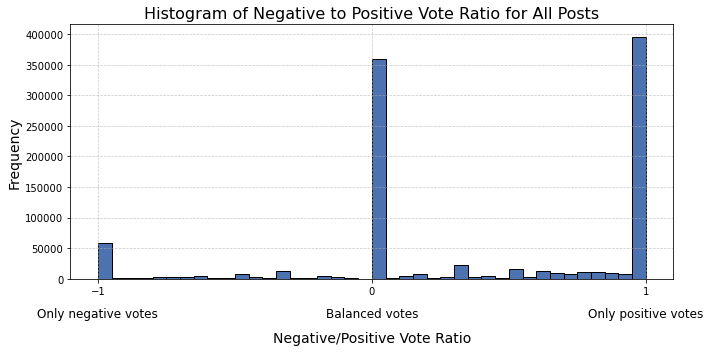

In [37]:
# Filter the data for "top posts" and plot a histogram for the Neg/Pos ratio
top_posts = df_merged

# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(top_posts['Neg_Pos_Ratio'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of Negative to Positive Vote Ratio for All Posts', fontsize=16)
plt.xlabel('Negative/Positive Vote Ratio', fontsize=14, labelpad=35)  # Add margin using labelpad
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate x axsis for improved clarity
plt.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

plt.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

plt.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )
plt.xlim(-1.1, 1.1)
plt.xticks([-1, 0, 1])

# Show the plot
plt.tight_layout()
plt.show()

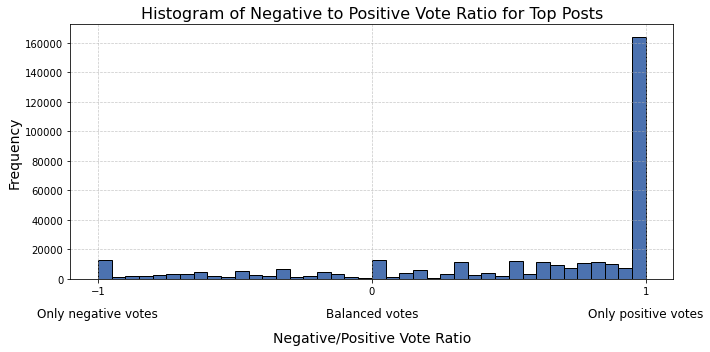

In [35]:
# Filter the data for "top posts" and plot a histogram for the Neg/Pos ratio
top_posts = df_merged[df_merged['Post_Engagement'] == 'top post']

# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(top_posts['Neg_Pos_Ratio'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of Negative to Positive Vote Ratio for Top Posts', fontsize=16)
plt.xlabel('Negative/Positive Vote Ratio', fontsize=14, labelpad=35)  # Add margin using labelpad
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate x axsis for improved clarity
plt.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

plt.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

plt.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )
plt.xlim(-1.1, 1.1)
plt.xticks([-1, 0, 1])

# Show the plot
plt.tight_layout()
plt.show()

### Step 2.1. Boxplot of Positive & Negative Votes

In order to get a feeling for how the values of Up- and Downvotes are distributed, we generate two boxplots, one for the upvotes feature, and one for the downvotes feature.

In [4]:
def make_box_plot(column, df):
    """
    Function to create a boxplot for a column in the dataframe
    Inputs:
    Name of the Column to make boxplot for (string)
    A Pandas data frame object 
    """

    # Set style
    sns.set_style("whitegrid")

    # Adjust the figure size
    plt.figure(figsize=(8, 2))

    # Create the box plot
    ax = sns.boxplot(x=df_posts[column], orient='h', fliersize=1, color='lightblue')

    # Set title
    ax.set_title("Distribution of " + column +  " (Log Scale)", fontsize=16)

    # Set x-axis label
    ax.set_xlabel("Number of "+ column, fontsize=14)

    # Remove y-axis label
    ax.set_ylabel("")

    # Set logarithmic scale for x-axis
    ax.set_xscale('log')

    # Set ticks on the x-axis
    custom_ticks = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 50, 100, 500]
    plt.xticks(custom_ticks, [str(i) for i in custom_ticks], fontsize=16)

    # Remove top and right spines
    sns.despine()
    
    # Save the plot
    plt.savefig('./figures/boxplot_' + column + '.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()

    


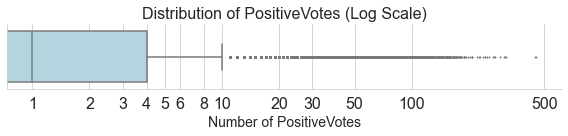

In [5]:
make_box_plot('PositiveVotes', df_posts)

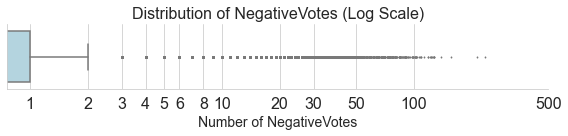

In [6]:
make_box_plot('NegativeVotes', df_posts)

### Step 2.2. Heatmap of Positive and Negtive Votes

In order to analyzse the distribution further, a heatmap is generated.

In [7]:
# Define custom intervals for PositiveVotes and NegativeVotes
positive_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]
negative_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]

# Create result DataFrame with named columns and rows
result_df = pd.DataFrame(0, index=[f'{interval[0]}-{interval[1]}' for interval in negative_intervals],
                         columns=[f'{interval[0]}-{interval[1]}' for interval in positive_intervals])

# Iterate through each post and update the count in the result DataFrame
for _, row in df_posts.iterrows():
    neg_interval = None
    pos_interval = None

    
    # Find the index of the negative interval
    for i, interval in enumerate(negative_intervals):
        if interval[0] <= row['NegativeVotes'] <= interval[1]:
            neg_interval = i
            break
            
    # Find the index of the positive interval
    for i, interval in enumerate(positive_intervals):
        if interval[0] <= row['PositiveVotes'] <= interval[1]:
            pos_interval = i
            break
    
    if neg_interval is not None and pos_interval is not None:
        result_df.iloc[neg_interval, pos_interval] += 1
        # row = interval for downvoates - column = interval for upvotes


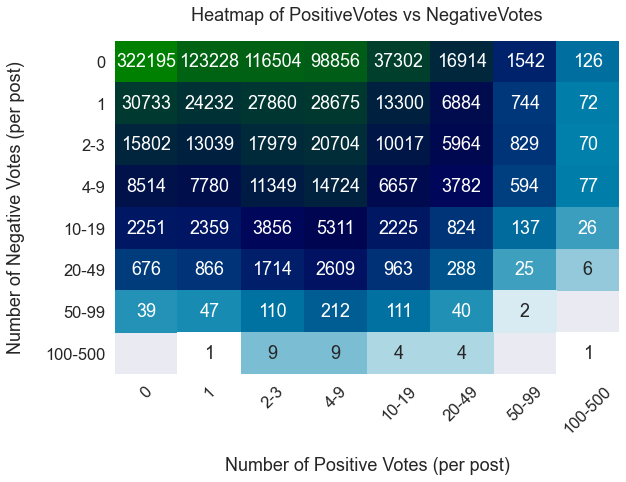

In [8]:

# Rename columns and index
result_df.rename(columns={'1-1': '1', '0-0': '0'}, 
                 index={'1-1': '1', '0-0': '0'}, 
                 inplace=True)

# Get the colormap 
cmap = cm.get_cmap('ocean')
# Flip the colormap
flipped_cmap = cmap.reversed()

# Set font scale for the heatmap and axis labels
sns.set(font_scale=1.5)  # Adjust font scale as needed

# Plot heatmap for PositiveVotes with logarithmic color scale
plt.figure(figsize=(10, 8))
sns.heatmap(result_df, cmap=flipped_cmap, annot=True, fmt='d', cbar=False, 
            norm=LogNorm(vmin=1, vmax=result_df.max().max()))
plt.title('Heatmap of PositiveVotes vs NegativeVotes', pad=20)  # Adjust title padding
plt.xlabel('Number of Positive Votes (per post)', labelpad=20)  # Adjust x label padding
plt.ylabel('Number of Negative Votes (per post)', labelpad=20)  # Adjust y label padding
plt.xticks(rotation=45)  # Rotate x ticks for better visibility
plt.yticks(rotation=0)   # Rotate y ticks for better visibility
plt.tight_layout(pad=3.0)  # Adjust padding between plot and figure edges


plt.savefig("./figures/heatmap.png", dpi=300, bbox_inches='tight' )
plt.show()


### Step 2.3. Overview of all posts

Next we generate an overview about how many posts have at least one vote (positive or negative), at least one positive or at least one negative votes.

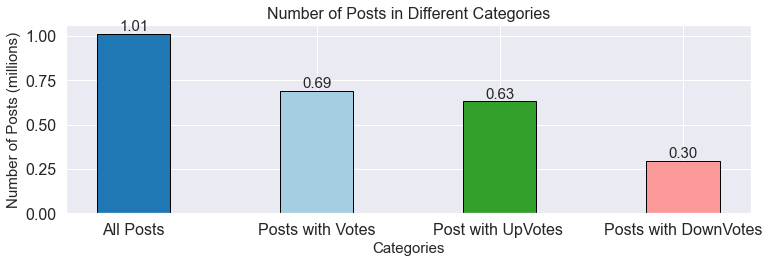

In [9]:
all_posts = df_posts["ID_Post"].count()
all_posts_with_votes = df_posts[(df_posts["PositiveVotes"] > 0) | (df_posts["NegativeVotes"] > 0)]["ID_Post"].count()
positive_posts = df_posts[(df_posts["PositiveVotes"] > 0)]["ID_Post"].count()
negative_posts = df_posts[(df_posts["NegativeVotes"] > 0)]["ID_Post"].count()

# Convert values to millions
all_posts /= 1e6
all_posts_with_votes /= 1e6
positive_posts /= 1e6
negative_posts /= 1e6

# Define categories and their corresponding values
categories = ['All Posts', 'Posts with Votes', 'Post with UpVotes ', 'Posts with DownVotes']
values = [all_posts, all_posts_with_votes, positive_posts, negative_posts]

# Choose a more suitable color palette
colors = ['#1F78B4', '#A6CEE3',   '#33A02C', '#FB9A99']
# Create bar plot
plt.figure(figsize=(11, 4))
bars = plt.bar(categories, values, color=colors, 
               edgecolor='black', width=0.4)  

# Add labels and title
plt.xlabel('Categories', fontsize=15)
plt.ylabel('Number of Posts (millions)', fontsize=15)
plt.title('Number of Posts in Different Categories', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the value on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=15)

# Save the plot
plt.savefig('./figures/bar_plot.png', dpi=300, bbox_inches='tight')
# Show plot
plt.tight_layout()
plt.show()



In [10]:
print(f"The median number of Upvotes is: { df_posts.PositiveVotes.median() }")
print(f"The median number of Downvotes is: { df_posts.NegativeVotes.median() }")


print(f"The mean number of Upvotes is: { df_posts.PositiveVotes.mean() }")
print(f"The mean number of Downvotes is: { df_posts.NegativeVotes.mean() }")

The median number of Upvotes is: 1.0
The median number of Downvotes is: 0.0
The mean number of Upvotes is: 3.7803005219550236
The mean number of Downvotes is: 1.0835434430450308


### Step 2.4. Looking at the Data

Next we look at a few example for posts with more than 10 upvotes or posts with more than 10 downvotes.

In [11]:
df_posts[df_posts["PositiveVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
108,,Ist es schon überarbeitet? Ich möchte wieder so berühmt werden wie früher. Das hat mir damals sagenhaft viele perverse Kontakte verschafft.
109,"""Multiuser"" und ""Bewertungsuser""?","Gibt es eine Meldeadresse/-stelle an die man sich wenden kann, wenn man annimmt einen ""Multiuser"" (mehrfach registrierten Benutzer) gefunden zu haben? Und was ist mit Usern die schon länger registriert sind, selbst 0 Postings verfasst haben und in Threads auffallend oft von oben bis unten durchgehend nur mit rot oder grün bewerten?"
157,Zugriff zu den eigenen ...,...posts bzw. Konto wäre eine gute Erweiterung....
189,"Oh, wie schön, heute ist m e i n Tag! :-)","Beste Grüße an alle Mit-Lefties dieser Erde und auch Nicht-Erde!!! Erfahrungen: # wirkliche Probleme, sehr eindrücklich als Kind zB beim Werken/Basteln, haben mir immer bestimmte Scheren gemacht (die z.B. dann total in der Hand weh tun, wenn links gehalten, oder einfach eher reißen als schneiden) # das eindrücklichste Erlebnis ist ein paar Jahre her: in einer Café-Lokation auf der Wiener Währinger Straße wurde mir meine Melange in einer Tasse serviert, deren ""ergonomisch"" schiefer/geschwungener Griff für eine rechte Hand (wohl) sehr gut passt - mit der linken Hand kann man das Häferl dadurch aber praktisch kaum halten... # beim Sporteln war mein Lefty-tum, glaub ich, immer nur ein Vorteil :-) ;-)"
206,,"wenn mir jemand bezüglich meiner handwerklichen Fähigkeiten gesagt hat, dass ich zwei Linke habe, habe ich mich für das Komplement bedankt."
215,,"am allerschlimmsten sind saucenschöpfer mit schnabel... da kann ich machen was ich will, ich kann diese teile einfach nicht bedienen.. die sauce rinnt überall hin, nur nicht auf den teller..."
289,,"Die Meinl-Häferln sind wirklich eine sinnlose Geschichte. Glückwunsch an den Designer für Hirnlosigkeit im Dienst - auch wenn es Linkshänder-Exemplare theoretisch geben tät, kein Restaurant würde die bestellen. Scheren sind ein kleines Problem, wobei ich mir mit einer Linkshänderschere auch weh tu - weil schon zu lange an die falschen Scheren gewohnt. Wenn man sich aber ausschließlich mit Linkshänderprodukten umgibt, ""sperrt"" man sih quasi von der dominierenden Rechtshänderwelt ab. Letztendlich drängt einem das Linkshändertum ein wenig, den Individualisten zu spielen - mir hat's nicht geschadet, oder ich merk's nicht."
297,,"Meine Großmutter hat mir mal erzählt, dass sie in der Schule noch geohrfeigt wurde, weil sie Linkshänderin war. Umlernen wurde gefordert, nicht nur in der Schule, sondern auch vom Elternhaus (natürlich auch mit Prügel verbunden) - kann mir nicht vorstellen, was für Leid das in einem Kind/Jugendlichen verursacht, wegen so einer Lappalie unter Druck gesetzt und verdroschen zu werden. Heute kann sie beide Hände fast gleich nutzen, präferiert bei den meisten Sachen jedoch die Linke."
347,,"Als Linkshänder, welcher die Computer Maus mit der rechten bedient, kann ich gleichzeitig etwas (ab)schreiben und mit der Maus am Computer zB Textstellen markieren und scrollen ;)"
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot


In [12]:
df_posts[df_posts["NegativeVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
235,,Zum Sport: Wer schießt (wie ich) beim Fußball mit rechts? Wer ist links unterwegs? rot=links grün=rechts
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot
759,,"schön. Bis zu jenem Tag, als die Trabis die Mariahilferstraße verstopft haben mit den Waschmaschinen am Dachl."
884,,"Ich hab jene Ostdeutschen bedauert, die den Versprechungen von Kohl und Genscher geglaubt haben."
1085,,"Wenn das so schlimm war, wieso hast sie dann überhaupt wiedergesehen? Oder wars nur für eine Nacht?"
1113,,das is ja wirklich grauslich - ich hätt' Euch auch nicht rein gelassen
1120,,In London gibts außergewöhnlich gute Hotels. Man muss sie sich halt leisten können und wollen. ;-)
1123,,DAnn frage ich dich nochmal: Was war damals an dem Erlebnis so schlimm?
1129,,"Im Nachhinein ist was anderes, ich glaube, hier gehts darum, welches Hotelerlebnis man im Moment des Erlebens als schlimm empfand. Also eher off topic, hier von kaputten späteren Beziehungen zu plaudern. :-)"
1251,,"dann graust mir davor, wie Dich Deine Ex-Frau umgedreht hat *brr*"


Most interestingly we see here for example that users misuse the functionality the downvotes and upvotes to start a survey (as shown in the first two rows).

## Step 2: Feature Generation

Next we generate the features to train our models with.

### Step 2.1: Main Feature Generation

In [67]:
# Function to calculate frequencies and ratios for various features
def calculate_frequency(text, pattern):
    """Calculate the frequency of a given pattern in the text."""
    if pd.isnull(text):
        return 0
    return len(re.findall(pattern, text))

def calculate_ratio(numerator, denominator):
    """Calculate the ratio of two values."""
    if denominator == 0:
        return 0
    return numerator / denominator


# Pre-compile regex patterns for reuse
patterns = {
    # Existing patterns
    'exclamation': re.compile(r'!'),
    'question': re.compile(r'(\W)*(\?|warum|wieso|weshalb|wozu)(\W)', re.IGNORECASE),
    'period': re.compile(r'\.'),
    'quote': re.compile(r'["\']'),
    'hashtag': re.compile(r'#'),
    'capital_letter': re.compile(r'[A-Z]'),
    'full_capital_words': re.compile(r'\b[A-Z]{2,}\b'),
    'emoji_positive': re.compile(r'(:-?\)|\(-?:|:D|:-?D|:P|:-?P|<3|:\^\)|:3|:>)'),
    'emoji_negative': re.compile(r'(:-?\(|\(-?:|\):|:\^\(|:\[|D:|D8|D-\(|:\||:-\||:/|:-/)'),
    'emoji_surprise': re.compile(r':o|:O|:-o|:-O'),
    'emoji_sarcastic': re.compile(r'(;-?\))'),
    'punctuation': re.compile(f'[{string.punctuation}]'),
    'exaggeration': re.compile(r'!!|\?\?'),
    'short_words': re.compile(r'\b\w{1,3}\b'),
    'long_words': re.compile(r'\b\w{10,}\b'),
    'gratitude': re.compile(r'(\W)*(danke(schön)*|bitte(schön)*|lieb)(\W)', re.IGNORECASE),
    
    # Pronouns and related patterns
    'first_person_singular': re.compile(r'(\W)*(ich|mich|mir|mein(e|r)*)(\W)', re.IGNORECASE),
    'first_person_plural': re.compile(r'(\W)*(wir|uns(e|r)*)(\W)', re.IGNORECASE),
    'second_person_plural': re.compile(r'(\W)*(ihr|euch|euer(e|r)*)(\W)', re.IGNORECASE),
    'third_person_plural': re.compile(r'(\W)*(sie|ihnen|ihr(e|r)*)(\W)', re.IGNORECASE),
    
    # Verb moods and tenses
    'conjunctive': re.compile(r'(\W)*(hätt(e|n)*|würd(e|n)*|wär(e|n)*|könnt(e|n)*|sollt(e|n)*|möcht(e|n)*|müsst(e|n)*)(\W)', re.IGNORECASE),
    'modal_verbs': re.compile(r'(\W)*(sollt(e|n)*|darf|muss|müssen|kann|können|wird|werden)(\W)', re.IGNORECASE),
    'past_tense': re.compile(r'(\W)*(war|damals|hatte|wurde|machte|ging|kam)(\W)', re.IGNORECASE),
    
    # Desire-related words
    'desire': re.compile(r'(\W)*(wollen|will|wünsch(t|e)*|möch(t|e)|sehn(t|e)|verlangen)(\W)', re.IGNORECASE),
    # contains a link to website
    'website': re.compile(r'(ht+ps*:\/\/|w+\.)*(\w+)\.(com|at|de|uk|org|net)(\S|\/)*', re.IGNORECASE)
}

def extract_features(df):
    """Integrate all features into the dataframe based on the full text column."""
    feature_df = df['FullText'].progress_apply(lambda full_text: {
        # Count frequencies
        'word_count': len(full_text.split()),
        'unique_words': len(set(full_text.split())),
        'character_count': len(full_text),
        'punctuation_count': sum(c in string.punctuation for c in full_text),
        'exclamation_frequency': calculate_frequency(full_text, patterns['exclamation']),
        'question_frequency': calculate_frequency(full_text, patterns['question']),
        'period_frequency': calculate_frequency(full_text, patterns['period']),
        'quote_frequency': calculate_frequency(full_text, patterns['quote']),
        'hashtag_frequency': calculate_frequency(full_text, patterns['hashtag']),
        'capital_letter_frequency': calculate_frequency(full_text, patterns['capital_letter']),
        'full_capital_words_frequency': calculate_frequency(full_text, patterns['full_capital_words']),
        'exaggeration_frequency': calculate_frequency(full_text, patterns['exaggeration']),
        'short_words_frequency': calculate_frequency(full_text, patterns['short_words']),
        'long_words_frequency': calculate_frequency(full_text, patterns['long_words']),
        'spelling_mistakes': 1 if re.search(r'\.\s*[a-zäöüß]|und[a-zäöüß]|oder[a-zäöüß]', full_text) else 0,
        # Ratios
        'emoji_to_text_ratio_pos': calculate_ratio(calculate_frequency(full_text, patterns['emoji_positive']), len(full_text)),
        'emoji_to_text_ratio_neg': calculate_ratio(calculate_frequency(full_text, patterns['emoji_negative']), len(full_text)),
        'emoji_to_text_ratio_sur': calculate_ratio(calculate_frequency(full_text, patterns['emoji_surprise']), len(full_text)),
        'emoji_to_text_ratio_sar': calculate_ratio(calculate_frequency(full_text, patterns['emoji_sarcastic']), len(full_text)),
        'punctuation_to_text_ratio': calculate_ratio(sum(c in string.punctuation for c in full_text), len(full_text)),
        'diversity_ratio': calculate_ratio(len(set(full_text.split())), len(full_text.split())),
        'avg_sentence_length': calculate_ratio(len(full_text.split()), len(re.split(r'[.!?]', full_text)) - 1) if len(re.split(r'[.!?]', full_text)) > 1 else 0,
        'avg_word_length': calculate_ratio(sum(len(word) for word in full_text.split()), len(full_text.split())),
        'words_per_100_chars': calculate_ratio(len(full_text.split()), len(full_text) / 100) if len(full_text) > 0 else 0,
        # Pronoun frequencies
        'first_person_singular_frequency': calculate_frequency(full_text, patterns['first_person_singular']),
        'first_person_plural_frequency': calculate_frequency(full_text, patterns['first_person_plural']),
        'second_person_plural_frequency': calculate_frequency(full_text, patterns['second_person_plural']),
        'third_person_plural_frequency': calculate_frequency(full_text, patterns['third_person_plural']),
        # Conjunctive and modal verbs
        'conjunctive_frequency': calculate_frequency(full_text, patterns['conjunctive']),
        'modal_verbs_frequency': calculate_frequency(full_text, patterns['modal_verbs']),
        # Past tense and desires
        'past_tense_frequency': calculate_frequency(full_text, patterns['past_tense']),
        'desire_frequency': calculate_frequency(full_text, patterns['desire']),
        # Gratitude words
        'gratitude_words': 1 if re.search(patterns['gratitude'], full_text) else 0,
    })

    # Convert feature rows to DataFrame
    feature_df = pd.DataFrame(feature_df.tolist())
    
    # Update original DataFrame with feature columns, overwriting any existing columns with the same names
    df.update(feature_df)
    
    # Add any new columns from feature_df that are not already in df
    new_columns = feature_df.columns.difference(df.columns)
    df[new_columns] = feature_df[new_columns]

    return df

# Apply feature extraction
df_merged = extract_features(df_merged)



100%|██████████████████████████████████████████████████████████████████████████████| 99993/99993 [01:06<00:00, 1508.38it/s]


### Step 2.2: Temporal Feature Generation

In [42]:
# Calculate the time difference in hours between 'CreatedAt' and 'publishingDate'
df_merged['publication_time'] = ( df_merged['CreatedAt'] - df_merged['publishingDate'] ).dt.total_seconds() / 60 / 60

# Rank the comments for each article based on the 'time_passed_before_post_creation'
#df_merged['publication_rank'] = df_merged.groupby('ID_Article')['publication_time'].rank(method='first').astype(int)

# Calculate the percentage rank (to check if it's in the first 10%, 20%, etc.)
df_merged['publication_rank'] = df_merged.groupby('ID_Article')['publication_time'].rank(pct=True)


### Step 2.3: Sentiment Feature Generation

In [43]:
# append the generated sentiment score (that was predicted in file sentiment analysis)
df_sentiment = pd.read_pickle("./data/sentiment_dataframe.pkl")[["ID_Post", "sentiment_score"]]
df_merged = df_merged.merge(df_sentiment, on="ID_Post", how="left")

In [44]:
df_merged["sentiment_score"]

0        0.000000
1       -0.926504
2        0.000000
3       -0.952935
4       -0.952714
           ...   
99988   -0.996573
99989   -0.990695
99990   -0.992424
99991   -0.963742
99992    0.000000
Name: sentiment_score, Length: 99993, dtype: float64

### Step 2.4. Train/Test Split

It is important to generate the train and test split before generating some of the features (as for example the TF-IDF) to avoid information leakage from the train to test set and therefore distort the result of the tests.

In [45]:
df_merged.columns

Index(['ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt',
       'Status', 'Headline', 'Body', 'PositiveVotes', 'NegativeVotes', 'Path',
       'publishingDate', 'Title', 'Subtitle', 'TotalInteraction', 'FullText',
       'article_post_count', 'title_length', 'body_length',
       'title_to_body_ratio', 'full_text_length', 'CleanedText',
       'stopwords_to_words_ratio', 'stop_words_count', 'Neg_Pos_Ratio',
       'Post_Engagement', 'avg_sentence_length', 'avg_word_length',
       'capital_letter_frequency', 'character_count', 'conjunctive_frequency',
       'desire_frequency', 'diversity_ratio', 'emoji_to_text_ratio_neg',
       'emoji_to_text_ratio_pos', 'emoji_to_text_ratio_sar',
       'emoji_to_text_ratio_sur', 'exaggeration_frequency',
       'exclamation_frequency', 'first_person_plural_frequency',
       'first_person_singular_frequency', 'full_capital_words_frequency',
       'gratitude_words', 'hashtag_frequency', 'long_words_frequency',
       'modal_verbs_f

In [70]:
# Define the initial X and y
X = df_merged.drop(columns=['PositiveVotes', 'NegativeVotes', 'TotalInteraction', 'Neg_Pos_Ratio', 'Post_Engagement'])
y = df_merged[['Post_Engagement', 'PositiveVotes', 'NegativeVotes', 'TotalInteraction', 'Neg_Pos_Ratio',]]

# Perform the train-test split only once
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 2.5: TF IDFs

In [71]:
# Step 1: Initialize and fit TfidfVectorizer on the training set only
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(X_train["CleanedText"])

# Step 2: Calculate average TF-IDF scores and select the top 200 terms
feature_names = vectorizer.get_feature_names()  # Use get_feature_names() for older versions of scikit-learn
average_tfidf_scores = tfidf_train.mean(axis=0).A1
top_200_indices = average_tfidf_scores.argsort()[::-1][:200]  # Indices of top 200 terms
top_200_features = [feature_names[i] for i in top_200_indices]

# Step 3: Refit the vectorizer to use only the top 200 terms
vectorizer_top_200 = TfidfVectorizer(vocabulary=top_200_features)
tfidf_train_top_200 = vectorizer_top_200.fit_transform(X_train["CleanedText"])
tfidf_test_top_200 = vectorizer_top_200.transform(X_test["CleanedText"])

# Step 4: Convert the TF-IDF matrices to DataFrames with proper column names
tfidf_train_df = pd.DataFrame(tfidf_train_top_200.toarray(), columns=[f"tfidf_{feature}" for feature in top_200_features])
tfidf_test_df = pd.DataFrame(tfidf_test_top_200.toarray(), columns=[f"tfidf_{feature}" for feature in top_200_features])

# Step 5: Reset indices to align DataFrames for concatenation
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Step 6: Concatenate the TF-IDF DataFrames with the original train and test DataFrames
X_train = pd.concat([X_train, tfidf_train_df], axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)


### Step 2.6: N-Grams

In [72]:
# Step 1: Initialize and fit TfidfVectorizer for bigrams (2-grams), trigrams (3-grams), and fourgrams (4-grams)
vectorizer_ngrams = TfidfVectorizer(ngram_range=(2, 4))  # This will include 2-grams, 3-grams, and 4-grams
tfidf_train_ngrams = vectorizer_ngrams.fit_transform(X_train["CleanedText"])

# Step 2: Calculate average TF-IDF scores and select the top 100 n-grams
feature_names_ngrams = vectorizer_ngrams.get_feature_names()  # Use get_feature_names() for older versions of scikit-learn
average_tfidf_scores_ngrams = tfidf_train_ngrams.mean(axis=0).A1
top_100_indices_ngrams = average_tfidf_scores_ngrams.argsort()[::-1][:150]  # Indices of top 100 n-grams
top_100_ngrams = [feature_names_ngrams[i] for i in top_100_indices_ngrams]

# Step 3: Refit the vectorizer to use only the top 100 n-grams (2-grams, 3-grams, 4-grams)
vectorizer_top_100_ngrams = TfidfVectorizer(vocabulary=top_100_ngrams, ngram_range=(2, 4))
tfidf_train_top_100_ngrams = vectorizer_top_100_ngrams.fit_transform(X_train["CleanedText"])
tfidf_test_top_100_ngrams = vectorizer_top_100_ngrams.transform(X_test["CleanedText"])

# Step 4: Convert the TF-IDF matrices to DataFrames with proper column names for n-grams
tfidf_train_ngrams_df = pd.DataFrame(tfidf_train_top_100_ngrams.toarray(), columns=[f"ngram_{feature}" for feature in top_100_ngrams])
tfidf_test_ngrams_df = pd.DataFrame(tfidf_test_top_100_ngrams.toarray(), columns=[f"ngram_{feature}" for feature in top_100_ngrams])

# Step 5: Concatenate the TF-IDF DataFrames for n-grams with the original train and test DataFrames
X_train = pd.concat([X_train, tfidf_train_ngrams_df], axis=1)
X_test = pd.concat([X_test, tfidf_test_ngrams_df], axis=1)

### Step 2.7: Feature Analysis

In [49]:
# Now print all columns
print(X_train.columns.to_list())

['ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 'Status', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 'Subtitle', 'FullText', 'article_post_count', 'title_length', 'body_length', 'title_to_body_ratio', 'full_text_length', 'CleanedText', 'stopwords_to_words_ratio', 'stop_words_count', 'avg_sentence_length', 'avg_word_length', 'capital_letter_frequency', 'character_count', 'conjunctive_frequency', 'desire_frequency', 'diversity_ratio', 'emoji_to_text_ratio_neg', 'emoji_to_text_ratio_pos', 'emoji_to_text_ratio_sar', 'emoji_to_text_ratio_sur', 'exaggeration_frequency', 'exclamation_frequency', 'first_person_plural_frequency', 'first_person_singular_frequency', 'full_capital_words_frequency', 'gratitude_words', 'hashtag_frequency', 'long_words_frequency', 'modal_verbs_frequency', 'past_tense_frequency', 'period_frequency', 'punctuation_count', 'punctuation_to_text_ratio', 'questionmark_frequency', 'quote_frequency', 'second_person_plural_frequency', 'short_wor

In [53]:
generated_features = [col for col in X_train.columns if col not in {
    'ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 
    'Status', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 
    'Subtitle', 'FullText', 'CleanedText',
}]

# Merge the features and target into a single DataFrame
df = X_train[generated_features].copy()
df['Post_Engagement'] = y_train["Post_Engagement"]

# Initialize a list to store the analysis results
results = []
# For each feature in X_train[generated_features], calculate the required metrics
for feature in X_train[generated_features].columns:
    # Directly extract the means for both 'regular post' and 'top post'

    mean_class_0 = df[df['Post_Engagement'] == 'regular post'][feature].mean()
    mean_class_1 = df[df['Post_Engagement'] == 'top post'][feature].mean()

    
    # Calculate the absolute and relative differences
    abs_diff = abs(mean_class_1 - mean_class_0)
    rel_diff = abs_diff / np.mean([mean_class_0, mean_class_1]) if mean_class_0 != 0 and mean_class_1 != 0 else 0


    
    # Store the results for the current feature
    results.append({
        'Feature': feature,
        'Regular_Post_Mean': mean_class_0,
        'Top_post_Mean': mean_class_1,
        'Abs_Diff': abs_diff,
        'Rel_Diff': rel_diff,
    })

# Convert the results to a DataFrame for easy inspection
analysis_df = pd.DataFrame(results)

# Rank features based on absolute difference, relative difference, and standard deviation difference
analysis_df['Rank_Abs_Diff'] = analysis_df['Abs_Diff'].rank(ascending=False)
analysis_df['Rank_Rel_Diff'] = analysis_df['Rel_Diff'].rank(ascending=False)

# Sort the DataFrame by the relative difference (you can adjust sorting criteria here)
analysis_df_sorted = analysis_df.sort_values(by='Rel_Diff', ascending=False)

# Display the final sorted DataFrame with the calculated results
analysis_df_sorted.style


,Feature,Regular_Post_Mean,Top_post_Mean,Abs_Diff,Rel_Diff,Rank_Abs_Diff,Rank_Rel_Diff
17,emoji_to_text_ratio_sur,0.000033,0.000007,0.000026,1.324701,362.000000,1.000000
40,publication_time,44.170104,78.617544,34.447440,0.561090,1.000000,2.000000
345,ngram_jeden tag,0.001666,0.000945,0.000721,0.552693,66.000000,3.000000
339,ngram_nach österreich,0.001403,0.000849,0.000553,0.491502,99.000000,4.000000
361,ngram_kein wunder,0.001318,0.000813,0.000506,0.474468,111.000000,5.000000
336,ngram_danke link,0.000462,0.000286,0.000176,0.470762,265.000000,6.000000
354,ngram_noch mal,0.000885,0.001418,0.000533,0.462876,105.000000,7.000000
296,ngram_gibt noch,0.002086,0.001316,0.000770,0.452739,60.000000,8.000000
343,ngram_nicht verstehen,0.001057,0.001655,0.000598,0.440938,90.000000,9.000000
346,ngram_menschen nicht,0.001260,0.001916,0.000656,0.413106,80.000000,10.000000


In [54]:
X_train[generated_features].columns

Index(['article_post_count', 'title_length', 'body_length',
       'title_to_body_ratio', 'full_text_length', 'stopwords_to_words_ratio',
       'stop_words_count', 'avg_sentence_length', 'avg_word_length',
       'capital_letter_frequency',
       ...
       'ngram_gibt viele', 'ngram_nicht gegen', 'ngram_immer nicht',
       'ngram_30 jahren', 'ngram_paar jahren', 'ngram_letzten jahre',
       'ngram_nicht wahr', 'ngram_sogar noch', 'ngram_nicht leisten',
       'ngram_nächstes jahr'],
      dtype='object', length=393)

## Step 3: Train & Evaluate Models

as a first step define those elements that are the same for both task: regression and classification.

In [91]:
y_train_classification = y_train['Post_Engagement']
y_test_classification = y_test['Post_Engagement']

y_train_regression = y_train['Neg_Pos_Ratio']
y_test_regression = y_test['Neg_Pos_Ratio']

# Function to tokenize and pad the textual data
def preprocess_text_column(column, tokenizer=None, max_len=100):
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(column)
    
    sequences = tokenizer.texts_to_sequences(column)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    return padded_sequences, tokenizer

# Preprocess text columns in train and test sets
max_len = 100
X_train_body, body_tokenizer = preprocess_text_column(X_train['Body'], max_len=max_len)
X_test_body = pad_sequences(body_tokenizer.texts_to_sequences(X_test['Body']), maxlen=max_len, padding='post')

X_train_headline, headline_tokenizer = preprocess_text_column(X_train['Headline'], max_len=max_len)
X_test_headline = pad_sequences(headline_tokenizer.texts_to_sequences(X_test['Headline']), maxlen=max_len, padding='post')

# Scale temporal features in train and test sets
scaler = StandardScaler()
X_train_temporal = scaler.fit_transform(X_train[['publication_time', 'publication_rank']])
X_test_temporal = scaler.transform(X_test[['publication_time', 'publication_rank']])


# Prepare labels
y_train_classification = (y_train_classification == 'top post').astype(int)  
y_test_classification = (y_test_classification == 'top post').astype(int)  


# Function to plot and save feature importance
def plot_feature_importances(features, importances, model_name):
    # Sort features by importance and select top 30
    top_n = 30
    indices = np.argsort(importances)[::-1][:top_n]
    top_features = np.array(features)[indices]
    top_importances = importances[indices]
    
    # Set a beautiful plot style
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    plt.barh(top_features, top_importances, color="skyblue", edgecolor="black")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel('Relative Importance')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    
    # Save plot to a file with the model name
    filename = f"./figures/feature_importances_{model_name}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close plot to avoid inline display
    
def train_lstm(model, X_train_body, X_train_headline, X_train_temporal, y):
    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=2,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
        verbose=1            # Verbosity mode
    )
    
    history = model.fit(
        [X_train_body, X_train_headline, X_train_temporal], y,
        epochs=10,  
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]  
    )
    
    return model

In [123]:
n_trees = 150
maxdepth = 10 
minsamplessplit = 20
maxsamplesleaf = 10
maxfeatures='log2'

random_forest_regression = RandomForestRegressor(
                n_estimators=n_trees,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=maxdepth,          # Limit depth to avoid overfitting
                min_samples_split=minsamplessplit,  # the number of samples required to split
                min_samples_leaf=maxsamplesleaf,    # the number of samples required at leaves
                max_features=maxfeatures    # The number of features at each split
            )

random_forest_classification = RandomForestClassifier(
                n_estimators=n_trees,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=maxdepth,          # Limit depth to avoid overfitting
                min_samples_split=minsamplessplit,  # the number of samples required to split
                min_samples_leaf=maxsamplesleaf,    # the number of samples required at leaves
                max_features=maxfeatures    # The number of features at each split
            )

# Define the training function with RandomForestRegressor
def train_explainable_model(features, y_train_regression, regression=True):
    
    if regression:
        model = random_forest_regression 
    else:
        model = random_forest_classification 
    
    
    # Wrap the model fitting in tqdm to track progress
    for _ in tqdm(range(model.n_estimators), desc="Training RandomForest"):
        model.fit(X_train[features], y_train_regression)  # Training step
        
    # Store feature importances
    feature_importances = model.feature_importances_
    
    return model, feature_importances

### Step 3.2: Regression Task

Finally we evaluate the models

In [111]:
generated_features_wo_sentiment = [col for col in X_train.columns if col not in {
    'ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 
    'Status', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 
    'Subtitle', 'FullText',  'CleanedText', 'sentiment_score'
}]

generated_features = [col for col in X_train.columns if col not in {
    'ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 
    'Status', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 
    'Subtitle', 'FullText', 'CleanedText',
}]


regression_models = {
    'Baseline_Regression': y_train_regression.mean(), 
    'Explainable_SimpleRegressionModel_RF': ['word_count', 'punctuation_count',
                            'unique_words', 'title_length', 'body_length',
                           'title_to_body_ratio', 'character_count'],
    'Explainable_ComplexRegressionModel_RF': generated_features_wo_sentiment,
    'Semi_Explainable_ComplexRegression_RF_BERT': generated_features
}

In [112]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units, return_sequences=False)(embedding_body)
dropout_body = Dropout(dropout_rate)(lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units, return_sequences=False)(embedding_headline)
dropout_headline = Dropout(dropout_rate)(lstm_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([dropout_body, dropout_headline, input_temporal])

# Add batch normalization for stability
batch_norm = BatchNormalization()(concatenated)

# Output layer with linear activation for regression
output = Dense(1, activation='linear')(batch_norm)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model with a regression loss function
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models['LSTM_Regression_Model'] = model

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 100, 64)      9360384     ['body_input[0][0]']             
                                                                                                  
 embedding_21 (Embedding)       (None, 100, 64)      1891072     ['headline_input[0][0]']         
                                                                                           

In [113]:

# Define hyperparameters
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Use Bidirectional LSTM
bi_lstm_body = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_body)
dropout_body = Dropout(dropout_rate)(bi_lstm_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Use Bidirectional LSTM
bi_lstm_headline = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_headline)
dropout_headline = Dropout(dropout_rate)(bi_lstm_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([dropout_body, dropout_headline, input_temporal])

# Add batch normalization for stability
batch_norm = BatchNormalization()(concatenated)

# Output layer with linear activation for regression
output = Dense(1, activation='linear')(batch_norm)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model with a regression loss function
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models['BiLSTM_Regression_Model'] = model


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 100, 64)      9360384     ['body_input[0][0]']             
                                                                                                  
 embedding_23 (Embedding)       (None, 100, 64)      1891072     ['headline_input[0][0]']         
                                                                                           

In [114]:



def calculate_regression_metrics(y_true, y_pred):
    """Calculate regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Updated evaluate_model_regression function to include feature importance plotting
def evaluate_model_regression(y_train_regression, y_test_regression, model=None, 
                              predict_baseline=False, explainable=False, lstm=False, 
                              features=None, model_name=None):
    """Evaluate model or baseline regression."""
    if predict_baseline:
        y_pred_train = [y_train_regression.mean()] * len(y_train_regression)
        y_pred_test = [y_test_regression.mean()] * len(y_test_regression)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
        
        # Plot feature importances after training RandomForest
        plot_feature_importances(features, model.feature_importances_, model_name)
        
    elif lstm:
        y_pred_train = model.predict([X_train_body, X_train_headline, X_train_temporal])
        y_pred_test = model.predict([X_test_body, X_test_headline, X_test_temporal])
    
    metrics_train = calculate_regression_metrics(y_train_regression, y_pred_train)
    metrics_test = calculate_regression_metrics(y_test_regression, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

def create_evaluation_df_regression(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'MSE': metrics[0], 'MAE': metrics[1], 'R2': metrics[2]},
        {'Model': model_name, 'Evaluation': 'Test', 'MSE': metrics[3], 'MAE': metrics[4], 'R2': metrics[5]}
    ])

# Evaluate each model
evaluation_regression_dfs = []

for model_name, X_baseline in regression_models.items():
    if 'baseline' in model_name.lower():
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         predict_baseline=True)

    elif 'explainable' in model_name.lower():
        trained_model, feature_importances = train_explainable_model(regression_models[model_name], y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         model=trained_model, explainable=True,
                                                         features=regression_models[model_name], 
                                                         model_name=model_name)
    elif 'lstm' in model_name.lower():
        model = regression_models[model_name]
        trained_model = train_lstm(model, X_train_body, X_train_headline, 
                                              X_train_temporal, y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, model=model, lstm=True)
        
    # Save results
    evaluation_df = create_evaluation_df_regression(model_name, metrics)
    evaluation_regression_dfs.append(evaluation_df)

# Combine evaluation results into one DataFrame
evaluation_regression_dfs = pd.concat(evaluation_regression_dfs, ignore_index=True)
evaluation_regression_dfs_sorted = evaluation_regression_dfs.sort_values(by='Evaluation', ascending=False)


Training RandomForest: 100%|█████████████████████████████████████████████████████████████| 150/150 [07:35<00:00,  3.04s/it]


Epoch 1/10
2000/2000 [==============================] - 318s 155ms/step - loss: 0.3695 - mae: 0.5277 - val_loss: 0.3675 - val_mae: 0.5268
Epoch 2/10
2000/2000 [==============================] - 299s 150ms/step - loss: 0.3497 - mae: 0.5143 - val_loss: 0.3667 - val_mae: 0.5277
Epoch 3/10
2000/2000 [==============================] - 304s 152ms/step - loss: 0.3323 - mae: 0.4962 - val_loss: 0.3799 - val_mae: 0.5350
Epoch 4/10
2000/2000 [==============================] - 299s 149ms/step - loss: 0.2853 - mae: 0.4357 - val_loss: 0.4035 - val_mae: 0.5383
Epoch 4: early stopping
625/625 [==============================] - 15s 23ms/step
Epoch 1/10
2000/2000 [==============================] - 380s 183ms/step - loss: 0.3718 - mae: 0.5275 - val_loss: 0.3649 - val_mae: 0.5259
Epoch 2/10
2000/2000 [==============================] - 369s 185ms/step - loss: 0.3008 - mae: 0.4520 - val_loss: 0.3834 - val_mae: 0.5253
Epoch 3/10
2000/2000 [==============================] - 372s 186ms/step - loss: 0.1957 - ma

In [115]:
evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"]

,Model,Evaluation,MSE,MAE,R2
1,Baseline_Regression,Test,0.357486,0.535153,1.110223e-16
3,Explainable_SimpleRegressionModel_RF,Test,0.357434,0.534037,1.439383e-04
5,Explainable_ComplexRegressionModel_RF,Test,0.353848,0.530468,1.017570e-02
7,Semi_Explainable_ComplexRegression_RF_BERT,Test,0.353926,0.530752,9.958051e-03
9,LSTM_Regression_Model,Test,0.360724,0.523713,-9.057537e-03
11,BiLSTM_Regression_Model,Test,0.357328,0.522367,4.408152e-04


In [117]:

latex_table = tabulate(evaluation_regression_dfs_sorted[evaluation_regression_dfs_sorted["Evaluation"] == "Test"], 
                       headers='keys', tablefmt='latex', showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

\begin{tabular}{llrrr}
\hline
 Model                                      & Evaluation   &     MSE &     MAE &           R2 \\
\hline
 Baseline\_Regression                        & Test         & 0.35749 & 0.53515 &  1.11022e-16 \\
 Explainable\_SimpleRegressionModel\_RF       & Test         & 0.35743 & 0.53404 &  0.000143938 \\
 Explainable\_ComplexRegressionModel\_RF      & Test         & 0.35385 & 0.53047 &  0.0101757   \\
 Semi\_Explainable\_ComplexRegression\_RF\_BERT & Test         & 0.35393 & 0.53075 &  0.00995805  \\
 LSTM\_Regression\_Model                      & Test         & 0.36072 & 0.52371 & -0.00905754  \\
 BiLSTM\_Regression\_Model                    & Test         & 0.35733 & 0.52237 &  0.000440815 \\
\hline
\end{tabular}


#### Bert (Standalone)

In [42]:
# Ensure all entries are strings and filter out non-string values
def preprocess_text_column(column):
    # Fill NaN values with empty strings and convert to list of strings
    column = column.fillna('').astype(str).tolist()
    # Ensure all entries are strings; filter out any that are not
    column = [str(text) for text in column if isinstance(text, str)]
    return column

# Apply preprocessing
X_train_body = preprocess_text_column(X_train['Body'])
X_test_body = preprocess_text_column(X_test['Body'])
X_train_headline = preprocess_text_column(X_train['Headline'])
X_test_headline = preprocess_text_column(X_test['Headline'])

# Define BERT input function
def bert_encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Encode text data for BERT model
X_train_body_encoded = bert_encode_texts(X_train_body, bert_tokenizer)
X_test_body_encoded = bert_encode_texts(X_test_body, bert_tokenizer)
X_train_headline_encoded = bert_encode_texts(X_train_headline, bert_tokenizer)
X_test_headline_encoded = bert_encode_texts(X_test_headline, bert_tokenizer)

# Extract input IDs and attention masks for both body and headline texts
X_train_body_ids = X_train_body_encoded['input_ids']
X_train_body_mask = X_train_body_encoded['attention_mask']
X_test_body_ids = X_test_body_encoded['input_ids']
X_test_body_mask = X_test_body_encoded['attention_mask']

X_train_headline_ids = X_train_headline_encoded['input_ids']
X_train_headline_mask = X_train_headline_encoded['attention_mask']
X_test_headline_ids = X_test_headline_encoded['input_ids']
X_test_headline_mask = X_test_headline_encoded['attention_mask']


In [145]:
# Load the DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-german-cased", from_pt=True)
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-german-cased", from_pt=True)

# Freeze some layers
for layer in distilbert_model.layers[:3]:  # Adjust based on experimentation
    layer.trainable = False


# Define your inputs 
input_body_ids = Input(shape=(64,), dtype=tf.int32, name='body_input_ids')
input_body_mask = Input(shape=(64,), dtype=tf.int32, name='body_attention_mask')
input_headline_ids = Input(shape=(64,), dtype=tf.int32, name='headline_input_ids')
input_headline_mask = Input(shape=(64,), dtype=tf.int32, name='headline_attention_mask')

# Get DistilBERT embeddings
distilbert_body_outputs = distilbert_model([input_body_ids, input_body_mask])
distilbert_output_body = distilbert_body_outputs.last_hidden_state[:, 0, :]

distilbert_headline_outputs = distilbert_model([input_headline_ids, input_headline_mask])
distilbert_output_headline = distilbert_headline_outputs.last_hidden_state[:, 0, :]

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')
concatenated = concatenate([distilbert_output_body, distilbert_output_headline, input_temporal])

# Output layer for regression
output = Dense(1, activation='linear')(concatenated)

# Compile model
distilbert_regression_model = Model(
    inputs=[input_body_ids, input_body_mask, input_headline_ids, input_headline_mask, input_temporal],
    outputs=output
)
distilbert_regression_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
bert_regression_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 body_attention_mask (InputLaye  [(None, 128)]       0           []                               
 r)                                                                                               
                                                                                                  
 headline_input_ids (InputLayer  [(None, 128)]       0           []                               
 )                                                                                                
                                                                                            

In [147]:
# Add the model to the regression models dictionary
regression_models['BERT'] = bert_regression_model

# Define the training function for BERT model
def train_bert_regression(model, X_train_body_ids, X_train_body_mask, 
                          X_train_headline_ids, X_train_headline_mask, 
                          X_train_temporal, y_train_regression):
    history = model.fit(
        [X_train_body_ids, X_train_body_mask, X_train_headline_ids, X_train_headline_mask, X_train_temporal], y_train_regression,
        epochs=3,  # Increase epochs as needed
        batch_size=16,  # BERT models are memory-intensive; adjust batch size accordingly
        validation_split=0.2
    )
    return model

# Update the evaluate_model_regression function for BERT
def evaluate_model_regression(y_train_regression, y_test_regression, model=None, 
                              predict_baseline=False, explainable=False, lstm=False, bert=False, 
                              features=None):
    """Evaluate model or baseline regression."""
    if predict_baseline:
        y_pred_train = [y_train_regression.mean()] * len(y_train_regression)
        y_pred_test = [y_test_regression.mean()] * len(y_test_regression)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
    elif lstm:
        y_pred_train = model.predict([X_train_body, X_train_headline, X_train_temporal])
        y_pred_test = model.predict([X_test_body, X_test_headline, X_test_temporal])
    elif bert:
        y_pred_train = model.predict([X_train_body_ids, X_train_body_mask, 
                                      X_train_headline_ids, X_train_headline_mask, 
                                      X_train_temporal])
        y_pred_test = model.predict([X_test_body_ids, X_test_body_mask, 
                                     X_test_headline_ids, X_test_headline_mask, X_test_temporal])
    
    metrics_train = calculate_regression_metrics(y_train_regression, y_pred_train)
    metrics_test = calculate_regression_metrics(y_test_regression, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

# Evaluate the BERT model
if 'BERT' in regression_models:
    bert_model = regression_models['BERT']
    trained_bert_model = train_bert_regression(bert_model, X_train_body_ids, X_train_body_mask, 
                                               X_train_headline_ids, X_train_headline_mask, 
                                               X_train_temporal, y_train_regression)
    metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, model=trained_bert_model, bert=True)
    evaluation_df = create_evaluation_df("BERT", metrics)
    evaluation_dfs.append(evaluation_df)

# Combine evaluation results into one DataFrame
evaluation_df_posts = pd.concat(evaluation_dfs, ignore_index=True)
evaluation_df_posts_sorted = evaluation_df_posts.sort_values(by='Evaluation', ascending=False)
print(evaluation_df_posts_sorted)


Epoch 1/3
   6/4000 [..............................] - ETA: 57:14:03 - loss: 27.5828 - mae: 3.6859

KeyboardInterrupt: 

### Step 3.1: Classification Task

In [124]:
classification_models = {
    'Baseline_Classification': y_train_regression.mean(), 
    'Explainable_SimpleClassificationModel_RF': ['word_count', 'punctuation_count',
                            'unique_words', 'title_length', 'body_length',
                           'title_to_body_ratio', 'character_count'],
    'Explainable_ComplexClassificationModel_RF': generated_features_wo_sentiment,
    'Semi_Explainable_Classification_RF_BERT': generated_features
}

In [125]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units)(embedding_body)
# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units)(embedding_headline)
# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')
# Concatenate all inputs
concatenated = concatenate([lstm_body, lstm_headline, input_temporal])
# Output layer
output = Dense(1, activation='sigmoid')(concatenated)
# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


classification_models['LSTM_Classification_Model'] = model



Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_28 (Embedding)       (None, 100, 64)      9360384     ['body_input[0][0]']             
                                                                                                  
 embedding_29 (Embedding)       (None, 100, 64)      1891072     ['headline_input[0][0]']         
                                                                                           

In [126]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
# Use Bidirectional LSTM
bi_lstm_body = Bidirectional(LSTM(lstm_units))(embedding_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
# Use Bidirectional LSTM
bi_lstm_headline = Bidirectional(LSTM(lstm_units))(embedding_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([bi_lstm_body, bi_lstm_headline, input_temporal])

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(concatenated)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Add the model to the classification models dictionary
classification_models['BiLSTM_Classification_Model'] = model


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 100, 64)      9360384     ['body_input[0][0]']             
                                                                                                  
 embedding_31 (Embedding)       (None, 100, 64)      1891072     ['headline_input[0][0]']         
                                                                                           

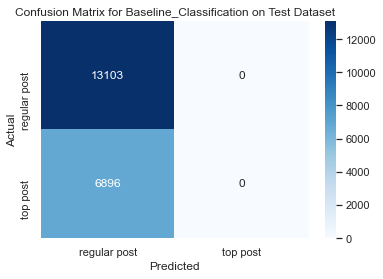

Training RandomForest: 100%|█████████████████████████████████████████████████████████████| 150/150 [05:54<00:00,  2.36s/it]


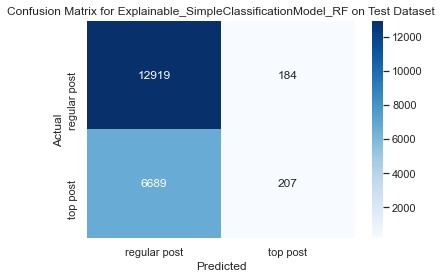

Training RandomForest: 100%|█████████████████████████████████████████████████████████████| 150/150 [08:57<00:00,  3.59s/it]


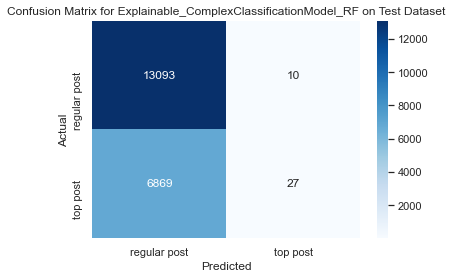

Training RandomForest: 100%|█████████████████████████████████████████████████████████████| 150/150 [09:26<00:00,  3.78s/it]


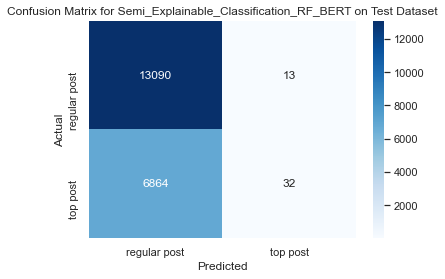

Epoch 1/10
2000/2000 [==============================] - 372s 182ms/step - loss: 0.6041 - accuracy: 0.6712 - val_loss: 0.5971 - val_accuracy: 0.6720
Epoch 2/10
2000/2000 [==============================] - 370s 185ms/step - loss: 0.5877 - accuracy: 0.6834 - val_loss: 0.5985 - val_accuracy: 0.6708
Epoch 3/10
2000/2000 [==============================] - 334s 167ms/step - loss: 0.5650 - accuracy: 0.6988 - val_loss: 0.6212 - val_accuracy: 0.6727
Epoch 3: early stopping
625/625 [==============================] - 16s 26ms/step


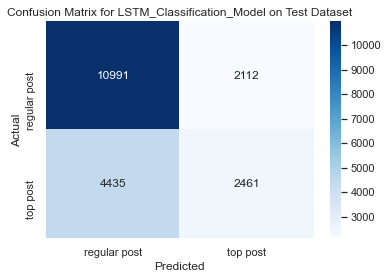

Epoch 1/10
2000/2000 [==============================] - 396s 191ms/step - loss: 0.5905 - accuracy: 0.6848 - val_loss: 0.5791 - val_accuracy: 0.6906
Epoch 2/10
2000/2000 [==============================] - 421s 210ms/step - loss: 0.4682 - accuracy: 0.7801 - val_loss: 0.6664 - val_accuracy: 0.6557
Epoch 3/10
2000/2000 [==============================] - 418s 209ms/step - loss: 0.2525 - accuracy: 0.8970 - val_loss: 0.9180 - val_accuracy: 0.6545
Epoch 3: early stopping
625/625 [==============================] - 20s 32ms/step


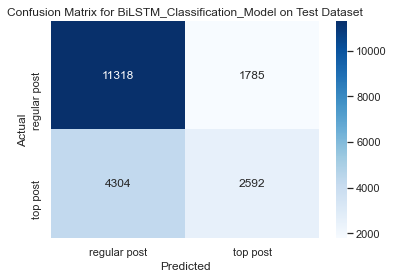

                                        Model Evaluation  Accuracy  Precision  \
0                     Baseline_Classification      Train  0.655737   0.000000   
2    Explainable_SimpleClassificationModel_RF      Train  0.665925   0.739284   
4   Explainable_ComplexClassificationModel_RF      Train  0.658349   0.933610   
6     Semi_Explainable_Classification_RF_BERT      Train  0.658262   0.939130   
8                   LSTM_Classification_Model      Train  0.674926   0.542627   
10                BiLSTM_Classification_Model      Train  0.731492   0.665809   
1                     Baseline_Classification       Test  0.655183   0.000000   
3    Explainable_SimpleClassificationModel_RF       Test  0.656333   0.529412   
5   Explainable_ComplexClassificationModel_RF       Test  0.656033   0.729730   
7     Semi_Explainable_Classification_RF_BERT       Test  0.656133   0.711111   
9                   LSTM_Classification_Model       Test  0.672634   0.538159   
11                BiLSTM_Cla

In [127]:
def calculate_classification_metrics(y_true, y_pred):
    """Calculate classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['regular post', 'top post'], 
                yticklabels=['regular post', 'top post'])
    plt.title(f'Confusion Matrix for {model_name} on Test Dataset')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_model_classification(y_train_classification, y_test_classification, model=None, 
                                  predict_baseline=False, 
                                  explainable=False,
                                  lstm=False,
                                  features=None, model_name=None):
    """Evaluate model or baseline classification."""
    if predict_baseline:
        y_pred_train = [0] * len(y_train_classification)
        y_pred_test = [0] * len(y_test_classification)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
        # Convert to binary predictions
        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        # Plot feature importances after training RandomForest
        plot_feature_importances(features, model.feature_importances_, model_name)
        
    elif lstm:
        y_pred_train = (model.predict([X_train_body, X_train_headline, X_train_temporal]) > 0.5).astype(int)
        y_pred_test = (model.predict([X_test_body, X_test_headline, X_test_temporal]) > 0.5).astype(int)
    
    metrics_train = calculate_classification_metrics(y_train_classification, y_pred_train)
    metrics_test = calculate_classification_metrics(y_test_classification, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

    

def create_evaluation_df_classification(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'Accuracy': metrics[0], 'Precision': metrics[1], 'Recall': metrics[2], 'F1': metrics[3]},
        {'Model': model_name, 'Evaluation': 'Test', 'Accuracy': metrics[4], 'Precision': metrics[5], 'Recall': metrics[6], 'F1': metrics[7]}
    ])




# Evaluate each model and plot confusion matrix
evaluation_dfs_classification = []
examples_df = pd.DataFrame(columns=['ModelName',  # which model
                                    'Type', #weather true positive (tp), true negative (tn), fp or fn
                                    'Example', # the body of that example
                                    'PositiveVotes',
                                    'NegativeVotes'])

for model_name, X_baseline in classification_models.items():
    
    if 'baseline' in model_name.lower():
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, predict_baseline=True)

    elif 'explainable' in model_name.lower():
        trained_model, feature_importances = train_explainable_model(classification_models[model_name], y_train_classification)
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, 
                                                         model=trained_model, explainable=True,
                                                         features=classification_models[model_name], 
                                                         model_name=model_name)
    elif 'lstm' in model_name.lower():
        model = classification_models[model_name]
        trained_model = train_lstm(model, X_train_body, X_train_headline, 
                                                  X_train_temporal, y_train_classification)
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, model=model, lstm=True)
        
    # save results
    evaluation_df = create_evaluation_df_classification(model_name, metrics)
    evaluation_dfs_classification.append(evaluation_df)
    

    # Plot confusion matrix for test dataset
    plot_confusion_matrix(y_test_classification, y_pred_test, model_name)

    # Collect examples of each kind (tp, tn, fp, fn)
    examples = {'True Positive': None, 'True Negative': None, 'False Negative': None, 'False Positive': None}
    for i in range(len(y_test_classification)):
        example_data = {
            'ModelName': model_name,
            'Example': df_merged['Body'].iloc[X_test.index[i]],
            'PositiveVotes': df_merged['PositiveVotes'].iloc[X_test.index[i]],
            'NegativeVotes': df_merged['NegativeVotes'].iloc[X_test.index[i]]
        }
        if y_test_classification.iloc[i] == 1:
            if y_pred_test[i] == 1 and examples['True Positive'] is None:
                examples['True Positive'] = {**example_data, 'Type': 'True Positive'}
            elif y_pred_test[i] == 0 and examples['False Negative'] is None:
                examples['False Negative'] = {**example_data, 'Type': 'False Negative'}
        elif y_pred_test[i] == 1 and examples['False Positive'] is None:
            examples['False Positive'] = {**example_data, 'Type': 'False Positive'}
        elif y_pred_test[i] == 0 and examples['True Negative'] is None:
            examples['True Negative'] = {**example_data, 'Type': 'True Negative'}
    # Append collected examples to examples_df
    for example_type, example in examples.items():
        if example is None:
            example = {
                'ModelName': model_name,
                'Type': example_type,
                'Example': None,
                'PositiveVotes': None,
                'NegativeVotes': None
            }
        examples_df = examples_df.append(example, ignore_index=True)
        
        

# Combine evaluation results into one DataFrame
evaluation_dfs_classification = pd.concat(evaluation_dfs_classification, ignore_index=True)
evaluation_dfs_classification_sorted = evaluation_dfs_classification.sort_values(by='Evaluation', ascending=False)
print(evaluation_dfs_classification_sorted)


In [128]:
evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"]

,Model,Evaluation,Accuracy,Precision,Recall,F1
1,Baseline_Classification,Test,0.655183,0.000000,0.000000,0.000000
3,Explainable_SimpleClassificationModel_RF,Test,0.656333,0.529412,0.030017,0.056814
5,Explainable_ComplexClassificationModel_RF,Test,0.656033,0.729730,0.003915,0.007789
7,Semi_Explainable_Classification_RF_BERT,Test,0.656133,0.711111,0.004640,0.009221
9,LSTM_Classification_Model,Test,0.672634,0.538159,0.356874,0.429157
11,BiLSTM_Classification_Model,Test,0.695535,0.592186,0.375870,0.459860


In [129]:
latex_table = tabulate(evaluation_dfs_classification[evaluation_dfs_classification["Evaluation"] == "Test"], 
                       headers='keys', tablefmt='latex', showindex=False, floatfmt=(".3f", ".3f", ".5f", ".5f"))

print(latex_table)

\begin{tabular}{llrrrr}
\hline
 Model                                     & Evaluation   &   Accuracy &   Precision &     Recall &         F1 \\
\hline
 Baseline\_Classification                   & Test         &    0.65518 &     0.00000 & 0          & 0          \\
 Explainable\_SimpleClassificationModel\_RF  & Test         &    0.65633 &     0.52941 & 0.0300174  & 0.0568135  \\
 Explainable\_ComplexClassificationModel\_RF & Test         &    0.65603 &     0.72973 & 0.00391531 & 0.00778884 \\
 Semi\_Explainable\_Classification\_RF\_BERT   & Test         &    0.65613 &     0.71111 & 0.00464037 & 0.00922057 \\
 LSTM\_Classification\_Model                 & Test         &    0.67263 &     0.53816 & 0.356874   & 0.429157   \\
 BiLSTM\_Classification\_Model               & Test         &    0.69553 &     0.59219 & 0.37587    & 0.45986    \\
\hline
\end{tabular}


In [29]:
examples_df

,ModelName,Type,Example,PositiveVotes,NegativeVotes
0,Baseline,True Positive,None,None,None
1,Baseline,True Negative,"Bist eigentlich nur da, um rote zu kassieren ...",0,0
2,Baseline,False Negative,Klingt glaubhaft - der letzte Teil.,23,1
3,Baseline,False Positive,None,None,None
4,Explainable Model 1,True Positive,nicht ein paar hunderttausend Flüchtlinge auf?...,4,0
5,Explainable Model 1,True Negative,"Bist eigentlich nur da, um rote zu kassieren ...",0,0
6,Explainable Model 1,False Negative,Klingt glaubhaft - der letzte Teil.,23,1
7,Explainable Model 1,False Positive,Bei 40€ Taschengeld ist in Versuchung schwarz ...,0,0
8,Explainable Model 2,True Positive,Außerdem könnte auch der Nitsch höhere Subvent...,3,0
9,Explainable Model 2,True Negative,"Bist eigentlich nur da, um rote zu kassieren ...",0,0


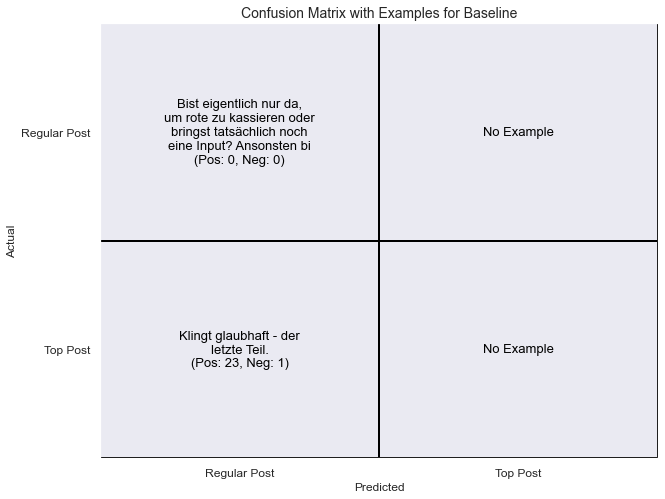

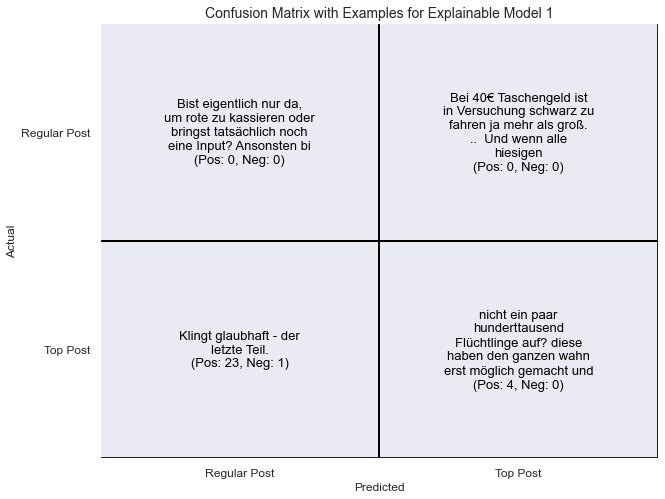

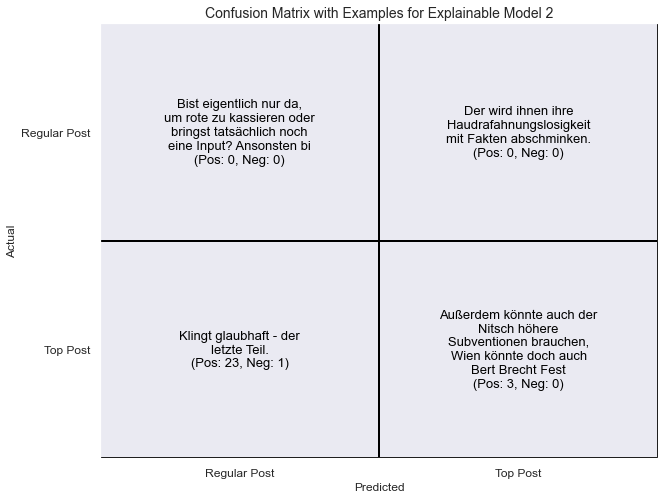

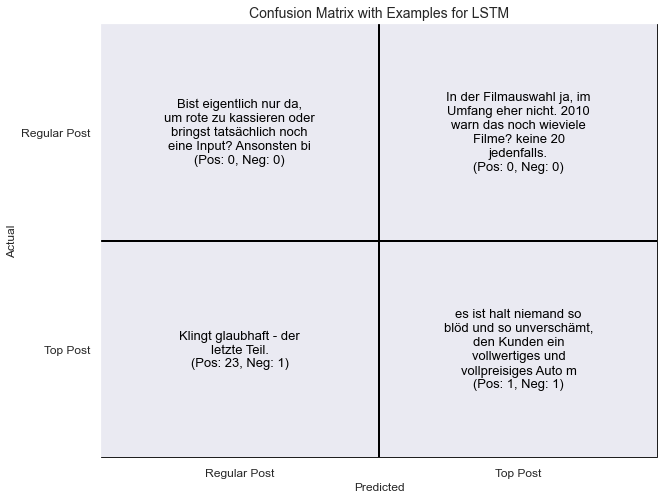

In [30]:

def format_example_text(example_text, pos_votes, neg_votes):
    """Format example text to display only the first 100 characters with line breaks every 25 characters."""
    if example_text:
        # Limit to 100 characters
        truncated_text = example_text[:100]
        # Create line breaks every 25 characters without cutting words
        wrapped_text = textwrap.fill(truncated_text, width=25)
        return f"{wrapped_text}\n(Pos: {pos_votes}, Neg: {neg_votes})"
    return "No Example"

def plot_confusion_matrix_of_examples(examples_df, model_name):
    """Plot the confusion matrix using the examples dataframe."""
    labels = ['Regular Post', 'Top Post']
    cm = [[0, 0], [0, 0]]  # Initialize confusion matrix counts

    # Fill confusion matrix based on examples_df
    for _, row in examples_df.iterrows():
        if row['Type'] == 'True Positive':
            cm[1][1] += 1
        elif row['Type'] == 'True Negative':
            cm[0][0] += 1
        elif row['Type'] == 'False Positive':
            cm[0][1] += 1
        elif row['Type'] == 'False Negative':
            cm[1][0] += 1

    plt.figure(figsize=(10, 8))  # Increase the overall size

    # Create a grid for the confusion matrix
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            # Draw rectangle for each cell
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))
            # Only annotate if there's a count
            if cm[i][j] > 0:
                # Find the corresponding example
                example_row = examples_df[(examples_df['Type'] == ('True Positive' if i == 1 and j == 1 else
                                                                    'True Negative' if i == 0 and j == 0 else
                                                                    'False Positive' if i == 0 and j == 1 else
                                                                    'False Negative'))]
                
                # Fetch the corresponding example text
                if not example_row.empty:
                    example = example_row.iloc[0]
                    formatted_text = format_example_text(example['Example'], 
                                                          example['PositiveVotes'], 
                                                          example['NegativeVotes'])
                else:
                    formatted_text = "No Example"
                    
                # Place the text in the center of each cell
                plt.text(j + 0.5, i + 0.5, formatted_text, ha='center', va='center', 
                         fontsize=13, color='black')

    # Set axis limits and labels
    plt.xlim(0, len(cm[0]))
    plt.ylim(0, len(cm))
    plt.title(f'Confusion Matrix with Examples for {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks([0.5, 1.5], labels, fontsize=12)
    plt.yticks([0.5, 1.5], labels, fontsize=12)
    plt.gca().invert_yaxis()  # Invert y axis to have the origin in the top left

    plt.grid(False)  # Disable the grid
    plt.axis('on')  # Show the axes
    plt.show()

# Example call to plot the confusion matrix using examples_df
for model_name in examples_df['ModelName'].unique():
    model_examples_df = examples_df[examples_df['ModelName'] == model_name]
    plot_confusion_matrix_of_examples(model_examples_df, model_name)
